In [235]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
# Import module for k-means
from sklearn.cluster import KMeans, DBSCAN
#import module k-prototype
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.max_columns', None)


# prepocessing sklearn
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

#Pour la localisation du coude
from kneed import KneeLocator, DataGenerator as dg

In [48]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [49]:
from collections import Counter

outre_cat=list((Counter(df.product_category.value_counts().index.to_list())-Counter(df.product_category.value_counts().index.to_list()[0:10])).elements())
outre_cat
df.replace(outre_cat,"other", inplace=True)
df.product_category.value_counts()

Home                   22393
Technology             13021
Health_Beauty          11351
Fashion_Accessories     8533
Toys_Games              7941
Sports_Leisure          7101
other                   6291
Construction_Tools      5003
Automotive              3722
Office_Supplies         3370
Baby                    2753
Name: product_category, dtype: int64

In [50]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )

In [51]:
df = transformer.fit_transform(df)
df=pd.DataFrame(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.001210,1.00,0.019164,0.029291,0.159712
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000161,0.75,0.002680,0.020235,0.164029
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000701,0.50,0.010120,0.042033,0.772662
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000311,0.75,0.003733,0.043034,0.461871
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.001714,1.00,0.026603,0.041227,0.414388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,0.013514,0.013514,0.013514,0.037741,1.00,0.116444,0.607084,0.643165
91475,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000686,0.75,0.009510,0.048062,0.376978
91476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000941,1.00,0.013224,0.055067,0.817266
91477,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.001135,1.00,0.016951,0.045621,0.171223


In [45]:
# Choose optimal K using Elbow method
inertia = []
for cluster in range(1, 10):
        kmeans = KMeans( n_clusters = cluster)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        print('Cluster initiation: {}'.format(cluster))
1	1	141.90	5.0	129.90	12.00	112
1	1	1	1	1	27.19	4.0	18.90	8.29	115
2	8	1	1	1	86.22	3.0	69.00	17.22	538
3	4	1	1	1	43.62	4.0	25.99	17.63	322
4	6	1	1	1	196.89	5.0	180.00	16.89	289
...	...	...	...	...	...	...	...	...	...
91474	10	2	2	2	4134.84	5.0	785.00	248.71	448
91475	1	1	1	1	84.58	4.0	64.89	19.69	263
91476	1	1	1


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Text(0, 0.5, 'Cout du modèle (inertia)')

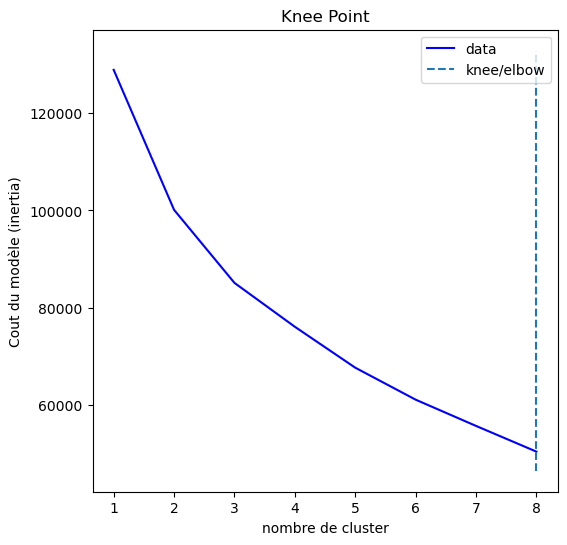

In [46]:
x,y = range(1,9),inertia[:-1]
kl = KneeLocator(x,y, curve='convex')
kl.plot_knee()
plt.xlabel('nombre de cluster')
plt.ylabel('Cout du modèle (inertia)')

In [52]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
kmeans.predict(df)

array([2, 1, 1, ..., 1, 1, 1], dtype=int32)

In [12]:
# df['cluster_labels']=pd.Series(kmeans.labels_)
# df.groupby('cluster_labels').describe()

payment_installments                                          \
                              count      mean       std  min  25%  50%  75%   
cluster_labels                                                                
0                            9226.0  3.540104  2.688804  1.0  1.0  3.0  5.0   
1                           18313.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
2                           18241.0  3.687956  2.920604  0.0  1.0  3.0  5.0   
3                            9862.0  2.517339  2.475036  0.0  1.0  1.0  3.0   
4                            7034.0  3.819448  2.785898  1.0  1.0  3.0  6.0   
5                           23174.0  3.340770  2.876070  1.0  1.0  2.0  5.0   
6                            5629.0  2.769231  2.486753  1.0  1.0  2.0  3.0   

                       orders                                                \
                 max    count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                                
0               24.0   9226.0  1.183395  0.677129  1.0  1.0  1.0  1.0  24.0   
1                1.0  18313.0  1.213346  0.737924  1.0  1.0  1.0  1.0  20.0   
2               24.0  18241.0  1.364180  1.168477  1.0  1.0  1.0  1.0  75.0   
3               24.0   9862.0  1.197222  0.744612  1.0  1.0  1.0  1.0  24.0   
4               24.0   7034.0  1.185812  0.657687  1.0  1.0  1.0  1.0  24.0   
5               24.0  23174.0  1.215543  0.789839  1.0  1.0  1.0  1.0  38.0   
6               24.0   5629.0  1.220465  0.700974  1.0  1.0  1.0  1.0  21.0   

               products                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                          
0                9226.0  1.183395  0.677129  1.0  1.0  1.0  1.0  24.0   
1               18313.0  1.213346  0.737924  1.0  1.0  1.0  1.0  20.0   
2               18241.0  1.364180  1.168477  1.0  1.0  1.0  1.0  75.0   
3                9862.0  1.197222  0.744612  1.0  1.0  1.0  1.0  24.0   
4                7034.0  1.185812  0.657687  1.0  1.0  1.0  1.0  24.0   
5               23174.0  1.215543  0.789839  1.0  1.0  1.0  1.0  38.0   
6                5629.0  1.220465  0.700974  1.0  1.0  1.0  1.0  21.0   

                sellers                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                          
0                9226.0  1.183395  0.677129  1.0  1.0  1.0  1.0  24.0   
1               18313.0  1.213346  0.737924  1.0  1.0  1.0  1.0  20.0   
2               18241.0  1.364180  1.168477  1.0  1.0  1.0  1.0  75.0   
3                9862.0  1.197222  0.744612  1.0  1.0  1.0  1.0  24.0   
4                7034.0  1.185812  0.657687  1.0  1.0  1.0  1.0  24.0   
5               23174.0  1.215543  0.789839  1.0  1.0  1.0  1.0  38.0   
6                5629.0  1.220465  0.700974  1.0  1.0  1.0  1.0  21.0   

               payment_value                                           \
                       count        mean          std    min      25%   
cluster_labels                                                          
0                     9226.0  192.857964   282.620985   9.59  69.7150   
1                    18313.0  212.999238   751.089263  12.28  57.0600   
2                    18241.0  218.640116   461.200514  13.78  69.4500   
3                     9862.0  195.881662  1220.546653  12.39  40.0900   
4                     7034.0  224.184990   309.074483  13.68  75.1625   
5                    23174.0  223.052175   494.697397  10.07  70.9025   
6                     5629.0  191.408200   286.878675  14.29  70.6500   

                                             review_score                      \
                    50%       75%        max        count      mean       std   
cluster_labels                                                                

In [200]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [114]:
a = FunctionTransformer(func=np.log1p)
preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
log=preprocessing.fit_transform(df)
log[0]

array([2.1972245773362196, 0.6931471805599453, 0.6931471805599453,
       0.6931471805599453, 4.9621450849358215, 1.791759469228055,
       4.874433672915854, 2.5649493574615367, 4.727387818712341,
       'credit_card', 'Home'], dtype=object)

In [109]:
kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
kprototype.fit_predict(log, categorical = [9,10])

array([0, 2, 0, ..., 0, 0, 0], dtype=uint16)

In [119]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (a,make_column_selector(dtype_include=np.number))
    )

transform_array=transformer.fit_transform(df)

df_log=pd.DataFrame(transform_array)

pipe_tsne = make_pipeline(transformer,TSNE()) 
array_tsne=pipe_tsne.fit_transform(df_log)

In [120]:


df_tsne=pd.DataFrame(array_tsne,columns=['f1','f2'])
df_tsne['cluster_labels']=pd.Series(kprototype.labels_)

df_tsne.groupby('cluster_labels').describe()

f1                                               \
                  count       mean        std         min        25%   
cluster_labels                                                         
0               36182.0  -7.407209  61.744591 -127.949379 -62.205286   
1               14100.0 -17.476286  55.634636 -114.663200 -59.998670   
2               27226.0  18.016830  59.660580 -127.916985 -27.554313   
3               13971.0   1.051694  55.229038 -125.036728 -44.307789   

                                                       f2             \
                      50%        75%         max    count       mean   
cluster_labels                                                         
0              -10.779665  37.292496  131.431152  36182.0   6.669052   
1              -20.381799  18.067651  131.352600  14100.0   4.695980   
2               26.440255  63.176668  132.736603  27226.0 -13.650376   
3               -0.729433  48.666428  130.325333  13971.0   4.909513   

                                                                        \
                      std         min        25%        50%        75%   
cluster_labels                                                           
0               60.210869 -120.301292 -35.771955   5.894869  54.464774   
1               49.417736 -111.139824 -29.744415   6.527676  46.538960   
2               67.670456 -134.997467 -69.465002 -21.217380  34.674914   
3               58.657417 -129.261826 -41.621489   1.877501  57.318092   

                            
                       max  
cluster_labels              
0               127.680733  
1               119.543457  
2               125.887268  
3               113.913689

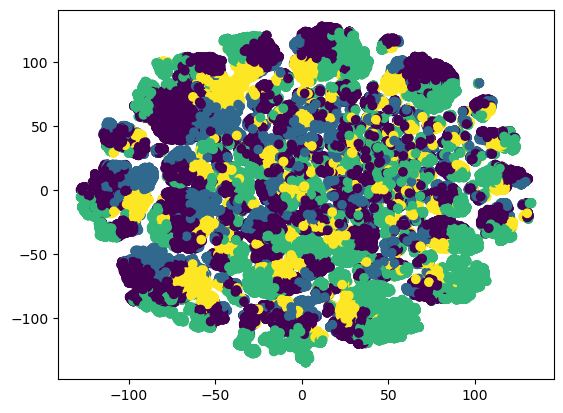

In [121]:
plt.scatter(df_tsne.f1,df_tsne.f2,c=df_tsne.cluster_labels)
plt.show()

In [228]:
a = FunctionTransformer(func=np.log1p)
preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
log=preprocessing.fit_transform(df)


transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (a,make_column_selector(dtype_include=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )

transform_array=transformer.fit_transform(df)

df_log=pd.DataFrame(transform_array)


pca = PCA(n_components=0.95)
df_pca=pd.DataFrame(pca.fit_transform(df_log))

clustering =KMeans(n_clusters=8).fit(df_pca)
df_pca['cluster_labels']=pd.Series(clustering.labels_)

df_pca.groupby('cluster_labels').describe()
df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,cluster_labels
0,0.633283,0.422231,-0.483176,-0.557178,0.429630,-0.471728,0.874046,0.420935,0.065101,0.200650,-0.100114,0.095117,0.084232,0.024244,-0.002742,2
1,-2.211966,0.539311,-0.175342,-0.262352,-0.116438,0.438529,0.225374,0.084369,-0.123732,-0.807958,-0.463615,-0.073780,-0.103432,-0.045747,-0.060429,0
2,-0.003074,-0.998057,-1.140613,-0.309777,0.333365,0.255418,-0.092682,-0.004625,-0.564779,0.315409,0.134387,0.034220,0.121993,0.195749,0.449364,5
3,-1.470379,-0.584532,-0.537712,-0.442573,0.483009,0.383054,0.102491,-0.642183,0.269464,0.489481,-0.281006,-0.032055,-0.008244,-0.061942,-0.039780,0
4,0.950906,-0.572987,-0.322303,-0.582401,-0.122735,0.291378,0.307551,-0.314156,0.322159,0.735747,-0.422937,0.037240,0.055776,-0.025066,-0.018965,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,4.522349,-1.502316,0.547353,-0.131523,0.864399,-0.178450,-0.079116,-1.827035,-0.253560,-0.910014,-0.511368,-0.278557,-0.191205,-0.255980,-0.105155,4
91475,-0.359497,-0.211859,-0.340767,0.058341,-0.375252,-0.046607,-0.619168,-0.022856,0.098802,-0.149679,0.101943,-0.049559,-0.002673,0.156567,0.233718,5
91476,0.009385,-1.056017,-0.385722,0.034778,-0.648454,-0.268170,-0.624858,-0.163661,0.111556,-0.146069,0.088342,-0.076236,0.001250,0.246025,0.783383,5
91477,0.508045,0.365952,-0.245918,-0.635522,-0.052148,0.145233,0.372278,-0.122391,-0.091167,0.115074,0.527992,-0.630061,-0.276691,-0.171678,-0.089242,2


In [161]:
pca.explained_variance_ratio_

array([0.34025243, 0.18916589, 0.09148749, 0.06324067, 0.04582296,
       0.04349137, 0.03848146, 0.03327484, 0.02694097, 0.02273659,
       0.01854877, 0.01682739, 0.01248241, 0.00955381])

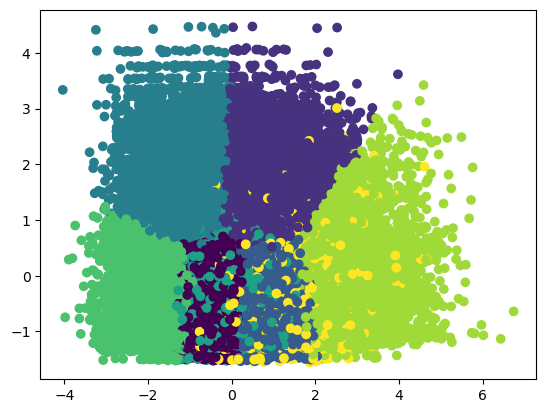

In [154]:
plt.scatter(df_pca.iloc[:,0],df_pca.iloc[:,1],c=df_pca.cluster_labels)
plt.show()

In [160]:
df['cluster_labels']=pd.Series(clustering.labels_)
df.groupby('cluster_labels').describe()

payment_installments                                           \
                              count      mean       std  min  25%  50%   75%   
cluster_labels                                                                 
0                           20969.0  2.464543  1.834193  1.0  1.0  2.0   3.0   
1                            8375.0  3.546627  2.796573  1.0  1.0  3.0   5.0   
2                           17093.0  4.612297  3.014045  1.0  2.0  4.0   7.0   
3                            7671.0  1.636814  1.254154  1.0  1.0  1.0   2.0   
4                           11469.0  1.000000  0.000000  1.0  1.0  1.0   1.0   
5                           13642.0  1.451034  0.905141  0.0  1.0  1.0   1.0   
6                            5977.0  6.023925  3.646888  1.0  3.0  6.0  10.0   
7                            6283.0  3.644756  3.122336  0.0  1.0  2.0   5.0   

                       orders                                                \
                 max    count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                                
0               10.0  20969.0  1.099480  0.330077  1.0  1.0  1.0  1.0   7.0   
1               20.0   8375.0  1.157373  0.469080  1.0  1.0  1.0  1.0   9.0   
2               24.0  17093.0  1.040367  0.197122  1.0  1.0  1.0  1.0   3.0   
3                9.0   7671.0  1.106244  0.396269  1.0  1.0  1.0  1.0   8.0   
4                1.0  11469.0  1.126951  0.398064  1.0  1.0  1.0  1.0   6.0   
5               10.0  13642.0  1.092948  0.440104  1.0  1.0  1.0  1.0  22.0   
6               24.0   5977.0  1.188389  0.556072  1.0  1.0  1.0  1.0  10.0   
7               24.0   6283.0  3.064460  2.194422  2.0  2.0  2.0  3.0  75.0   

               products                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                          
0               20969.0  1.099480  0.330077  1.0  1.0  1.0  1.0   7.0   
1                8375.0  1.157373  0.469080  1.0  1.0  1.0  1.0   9.0   
2               17093.0  1.040367  0.197122  1.0  1.0  1.0  1.0   3.0   
3                7671.0  1.106244  0.396269  1.0  1.0  1.0  1.0   8.0   
4               11469.0  1.126951  0.398064  1.0  1.0  1.0  1.0   6.0   
5               13642.0  1.092948  0.440104  1.0  1.0  1.0  1.0  22.0   
6                5977.0  1.188389  0.556072  1.0  1.0  1.0  1.0  10.0   
7                6283.0  3.064460  2.194422  2.0  2.0  2.0  3.0  75.0   

                sellers                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster_labels                                                          
0               20969.0  1.099480  0.330077  1.0  1.0  1.0  1.0   7.0   
1                8375.0  1.157373  0.469080  1.0  1.0  1.0  1.0   9.0   
2               17093.0  1.040367  0.197122  1.0  1.0  1.0  1.0   3.0   
3                7671.0  1.106244  0.396269  1.0  1.0  1.0  1.0   8.0   
4               11469.0  1.126951  0.398064  1.0  1.0  1.0  1.0   6.0   
5               13642.0  1.092948  0.440104  1.0  1.0  1.0  1.0  22.0   
6                5977.0  1.188389  0.556072  1.0  1.0  1.0  1.0  10.0   
7                6283.0  3.064460  2.194422  2.0  2.0  2.0  3.0  75.0   

               payment_value                                                   \
                       count        mean          std     min     25%     50%   
cluster_labels                                                                  
0                    20969.0   87.448592    28.536430   41.68   66.33   82.22   
1                     8375.0  217.842663   154.698267   78.11  131.37  170.97   
2                    17093.0  188.192593    60.364000   90.17  143.27  173.82   
3                     7671.0   65.655513    34.776142    9.59   44.18   59.87   
4                    11469.0  136.662726    76.724890   48.72   78.65  115.01   
5       

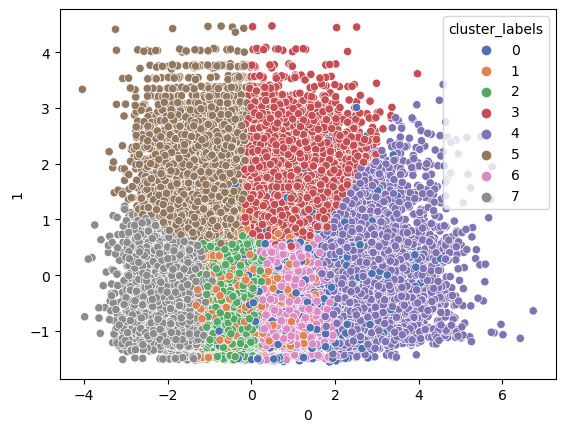

In [149]:
sns.scatterplot(data=df_pca, x=0,y=1, hue='cluster_labels', palette='deep')
plt.show()

In [124]:
# a = FunctionTransformer(func=np.log1p)
# preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
# log=preprocessing.fit_transform(df)

# kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
# kprototype.fit_predict(log, categorical = [9,10])

# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
#     (a,make_column_selector(dtype_include=np.number))
#     )

# transform_array=transformer.fit_transform(df)

# df_transform=pd.DataFrame(transform_array)


# pca = PCA(n_components=0.95)
# df_pca=pd.DataFrame(pca.fit_transform(df_transform))

# df_pca['cluster_labels']=pd.Series(kprototype.labels_)

# df_pca.groupby('cluster_labels').describe()

# plt.scatter(df_pca.iloc[:,0],df_pca.iloc[:,1],c=df_pca.cluster_labels)
# plt.show()

f1                                                    \
                  count      mean       std       min       25%       50%   
cluster_labels                                                              
0               36182.0  0.269302  0.479563 -0.739226 -0.127198  0.259433   
1               14100.0  2.039527  0.789750  0.674333  1.438097  1.820902   
2               27226.0 -1.330522  0.565643 -3.979125 -1.716944 -1.242614   
3               13971.0 -0.162940  0.900872 -4.032302 -0.772653 -0.124715   

                                         f2                                \
                     75%       max    count      mean       std       min   
cluster_labels                                                              
0               0.654620  1.385133  36182.0 -0.387238  0.488569 -1.434815   
1               2.451766  6.731699  14100.0 -0.082386  0.747309 -1.439737   
2              -0.857410 -0.399303  27226.0 -0.296800  0.563275 -1.405327   
3               0.492475  3.005466  13971.0  1.664403  0.687679  0.496728   

                                                        
                     25%       50%       75%       max  
cluster_labels                                          
0              -0.795234 -0.435813 -0.025884  0.844789  
1              -0.653564 -0.203596  0.360255  3.619074  
2              -0.747072 -0.359895  0.083994  2.205270  
3               1.080961  1.580487  2.090979  4.498288

In [178]:
make_column_selector(dtype_exclude=np.number)

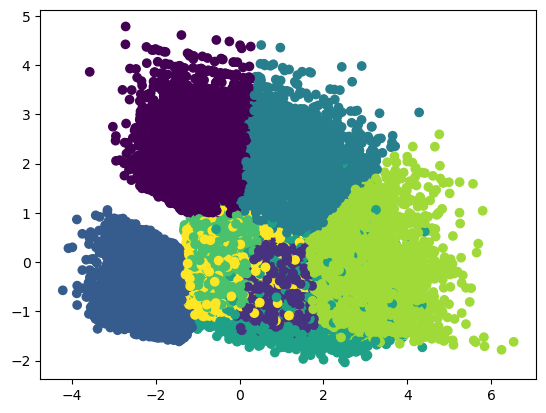

In [283]:
func_log = FunctionTransformer(func=np.log1p)
func_abs=FunctionTransformer(func=np.abs)

pipe_num= make_pipeline(func_abs,func_log)

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
    (pipe_num,make_column_selector(dtype_include=['float','int']))
    )

pipe_pca= make_pipeline(transformer,PCA(n_components=0.95))

df_acp=pd.DataFrame(pipe_pca.fit_transform(df))


clustering =KMeans(n_clusters=8).fit(df_acp)
df_acp['cluster_labels']=pd.Series(clustering.labels_)

df_acp.groupby('cluster_labels').mean()

plt.scatter(df_acp.iloc[:,0],df_acp.iloc[:,1],c=df_acp.cluster_labels)
plt.show()

In [284]:
df_num=df[['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency']]
df_num

,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,8,1,1,1,141.90,5.0,129.90,12.00,112
1,1,1,1,1,27.19,4.0,18.90,8.29,115
2,8,1,1,1,86.22,3.0,69.00,17.22,538
3,4,1,1,1,43.62,4.0,25.99,17.63,322
4,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...
91474,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,5,1,1,1,133.69,5.0,115.00,18.69,120


In [303]:
mms=MinMaxScaler(feature_range=(1,5))

num_cols= df.select_dtypes(include='number').columns.tolist()
df_num['cluster_labels']=pd.Series(clustering.labels_)

list_agg = {}
for col in num_cols:
    list_agg[f'{col}'] = 'mean'

df_mean=df_num.groupby('cluster_labels').agg(list_agg)
df_mean=df_mean.drop('cluster_labels', axis=1)

df_mms=pd.DataFrame(mms.fit_transform(df_mean),columns=['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency'])
df_mms

/tmp/ipykernel_16186/976803825.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,1.506212,1.131201,1.131201,1.131201,1.124385,5.000000,1.131369,1.210636,1.000000
1,3.842916,1.000000,1.000000,1.000000,1.715522,3.942447,1.928141,2.195914,5.000000
2,1.356303,1.103498,1.103498,1.103498,1.000000,4.200559,1.000000,1.000000,4.835492
3,3.054197,1.228921,1.228921,1.228921,1.873179,4.911011,1.884531,2.718220,1.063274
4,3.113312,5.000000,5.000000,5.000000,4.502342,1.000000,1.412374,1.631287,4.554771
5,2.185137,1.118000,1.118000,1.118000,1.227318,4.146336,1.275189,1.292511,4.802172
6,5.000000,1.286106,1.286106,1.286106,5.000000,3.503328,5.000000,5.000000,4.317802
7,1.000000,1.165445,1.165445,1.165445,1.471304,3.989102,1.522233,1.774895,4.836923


In [ ]:
num_cols= df.select_dtypes(include='number').columns.tolist()

In [304]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=num_cols,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)